In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')

import sys, importlib
module_name = "Functions"
if module_name in sys.modules:
    del sys.modules[module_name]
Functions = importlib.import_module(module_name)

from Functions_HuggingFace import *

import esm
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pd 
import numpy as np
import torch



import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO

from Bio import Entrez
from Bio import SeqIO

from transformers import EsmForMaskedLM, T5EncoderModel,T5Tokenizer,DataCollatorForLanguageModeling
from transformers.modeling_outputs import MaskedLMOutput


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Run code

In [4]:
model_layers = 36

model_raw, alphabet = esm.pretrained.load_model_and_alphabet('esm2_t36_3B_UR50D')
model_raw.eval()
batch_converter = alphabet.get_batch_converter()

sub_mod='ESM2-H3'
sub_mod='ESM2-HA80'
modnam="/home3/oml4h/hugging_face_downloads/model_weights_topublish/{}".format(sub_mod)


model = EsmForMaskedLM.from_pretrained(modnam)



if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Transferred model to GPU")

else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")
model =  model.to(device)


Transferred model to GPU


In [5]:
sequences = read_sequences_to_dict('/home2/oml4h/PLM_SARS-CoV-2/Sequences/huH3N2_HA_CDS.translated.fas')
sequences

{'EPI2178977|HA|A/Thailand/8/2022|EPI_ISL_14991375|J': 'MKAIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQISGKLNRLIGKTNEKFHQIEKEFSEVEGRVQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNETYDHNVYRDEALNNRFQIKGVELKSGYKDWILWISFAMSCFLLCIALLGFIMWACQKGNIRCNICIX',
 'EPI2096148|HA|A/Massachusetts/18/2022|EPI_ISL_13897082|J': 'MKAIIALSNILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQN

In [6]:
ids=list(sequences.keys())




In [7]:
J_indexed_muts = [m for m in get_reference_mutations(ref = sequences[ids[0]],mut = sequences[ids[len(ids)-1]]) if "-" not in m  ] 
K_indexed_muts = [m for m in get_mutations(sequences[ids[0]],sequences[ids[len(ids)-1]]) if "del" not in m and '-' not in m  ] 
print("K->J mutations")
print(K_indexed_muts)

K->J mutations
['K18N', 'N138D', 'T151K', 'S160N', 'N174D', 'I176K', 'Q189R', 'K205R', 'K292E', 'T344A', 'S394N']


In [8]:
mutation_dictionary  = {k:J_indexed_muts[i] for i,k in enumerate(K_indexed_muts)}

In [9]:
# get info on model layers:
model_layers_info = model.config.to_dict()
print(model_layers_info)
#print how many layers the model has
print("Number of layers in the model: ", model_layers_info['num_hidden_layers'] + 1)  # +1 for the embedding layer

{'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': 'float32', 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'chunk_size_feed_forward': 0, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'typical_p': 1.0, 'repetition_penalty': 1.0, 'length_penalty': 1.0, 'no_repeat_ngram_size': 0, 'encoder_no_repeat_ngram_size': 0, 'bad_words_ids': None, 'num_return_sequences': 1, 'output_scores': False, 'return_dict_in_generate': False, 'forced_bos_token_id': None, 'forced_eos_token_id': None, 'remove_invalid_values': False, 'exponential_decay_length_penalty': None, 'suppress_tokens': None, 'begin_supp

In [10]:

#pd.DataFrame(columns=["Mutation","rel_grammar","rel_seq_grammar","semanatic_score","probability","Backbone"])
mut_info_rows=[]

#loop through each node in the tree except the last one (lineage of interest)
for backbone_i in range(len(ids)-1):
    backbone = ids[backbone_i]
    print("Calculating mutations on backbone:",backbone)
    reference_spike_sequence = sequences[backbone]
    #calculate mutation differences between node and K lineage
    J_indexed_muts = [m for m in get_reference_mutations(ref = sequences[backbone],mut = sequences[ids[len(ids)-1]]) if "-" not in m  ] 
    K_indexed_muts = [m for m in get_mutations(sequences[backbone],sequences[ids[len(ids)-1]]) if "del" not in m and '-' not in m  ] 
    mutation_dictionary  = {k:J_indexed_muts[i] for i,k in enumerate(K_indexed_muts)}
    print("K->J mutations")
    print(K_indexed_muts)
    #loop through each mutation and calculate the scores on the focal node
    for mut in mutation_dictionary.keys():
        if backbone ==  ids[len(ids)-1]:
            sequence = revert_sequence(reference_spike_sequence,[mut])
        else:
            sequence = mutate_sequence(reference_spike_sequence,[mut])
        reference = reference_spike_sequence
        mutations = embed_protein_sequences(
            [[mut,sequence.replace("-","")]],
            reference.replace("-",""),
            'S:0',
            model,
            model_layers,
            device,
            batch_converter,
            alphabet,
            scores=True)
   
        
        #append mutation info to dataframe
        new_row={"Mutation":mut,"rel_grammar":mutations[mut]["S:0"]["relative_grammaticality"],
                                    "rel_seq_grammar":mutations[mut]["S:0"]["relative_sequence_grammaticality"],
                                    "narrow_seq_grammar":mutations[mut]["S:0"]["narrow_sequence_grammaticality"],
                                    "relative_narrow_seq_grammar":mutations[mut]["S:0"]["relative_narrow_sequence_grammaticality"],
                                    "semanatic_score":mutations[mut]["S:0"]["semantic_score"],
                                    "probability":mutations[mut]["S:0"]["probability"],
                                    "Backbone":backbone}
        mut_info_rows.append(new_row)
        
    
mut_info=pd.DataFrame(mut_info_rows)

Calculating mutations on backbone: EPI2178977|HA|A/Thailand/8/2022|EPI_ISL_14991375|J
K->J mutations
['K18N', 'N138D', 'T151K', 'S160N', 'N174D', 'I176K', 'Q189R', 'K205R', 'K292E', 'T344A', 'S394N']
[['K18N', 'MKAIIALSNILCLVFAQNIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQISGKLNRLIGKTNEKFHQIEKEFSEVEGRVQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNETYDHNVYRDEALNNRFQIKGVELKSGYKDWILWISFAMSCFLLCIALLGFIMWACQKGNIRCNICIX']]
[['K18N', 'MKAIIALSNILCLVFAQNIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQ

In [11]:
#
mut_info["lineage_backbone"]=mut_info["Backbone"].str.split("|").str[-1]
mut_info
mut_info.to_csv("/home3/oml4h/PLM_SARS-CoV-2/Results/H3_epistasis_mutation_info_spyros_model_{}.csv".format(sub_mod)
,index=False)
print(mut_info.loc[mut_info['Mutation']=='I176K'])
print(mut_info.loc[mut_info['Mutation']=='I151K'])

   Mutation  rel_grammar  rel_seq_grammar  narrow_seq_grammar  \
5     I176K     1.862888        -0.727318          -68.000420   
16    I176K     1.862888        -0.727318          -68.000420   
27    I176K     2.105804        -0.173820          -72.118584   
37    I176K     2.105804        -0.173820          -72.118584   
45    I176K     2.296327         0.122482          -72.571007   

    relative_narrow_seq_grammar  semanatic_score  probability  \
5                     -3.421188         4.449192     0.410616   
16                    -3.421188         4.449192     0.410616   
27                    -2.906601         4.344539     0.516132   
37                    -2.906601         4.344539     0.516132   
45                    -2.810661         4.284155     0.506666   

                                             Backbone lineage_backbone  
5   EPI2178977|HA|A/Thailand/8/2022|EPI_ISL_149913...                J  
16  EPI2096148|HA|A/Massachusetts/18/2022|EPI_ISL_...                J  

# do each mutation by itself and then do each pairwise comparison 

In [12]:
backbone_id=ids[4]
K_indexed_muts = [m for m in get_mutations(sequences[backbone_id],sequences[ids[len(ids)-1]]) if "del" not in m and '-' not in m  ] 
print("K->J mutations")
print(K_indexed_muts)



K->J mutations
['K18N', 'S160N', 'N174D', 'I176K', 'Q189R', 'T344A', 'S394N']


In [13]:
# backbone = "Wuhan-Hu-1"

backbone=backbone_id
reference_spike_sequence = sequences[backbone]

#create dict of point mutation backbones for all of the mutations in  K_indexed_muts, with names as keys
point_mutations={}
for mut in K_indexed_muts:
    point_mutations[mut]=mutate_sequence(reference_spike_sequence,[mut])

mut_info_rows=[]
plm_entropy=[]
plm_probability=[]

#loop through each point mutation
for backbone_i in range(len(K_indexed_muts)+1):
    
    if backbone_i == len(K_indexed_muts):
        backbone = reference_spike_sequence
        backbone_name="Reference"
    else:
        backbone = point_mutations[list(point_mutations.keys())[backbone_i]]
        backbone_name=list(point_mutations.keys())[backbone_i]
    
    for mutation_j in range(len(K_indexed_muts)):
        if backbone_i == mutation_j:
            print(f"Skipping mutation {K_indexed_muts[mutation_j]} on its own backbone")
            continue
        mut=K_indexed_muts[mutation_j]
        mutate_sequence(reference_spike_sequence,[mut])
        
   

        sequence = mutate_sequence(backbone,[mut])

        reference = backbone
        mutations = embed_protein_sequences(
            [[mut,sequence.replace("-","")]],
            backbone.replace("-",""),
            'S:0',
            model,
            model_layers,
            device,
            batch_converter,
            alphabet,
            scores=True)
        


        
        #append mutation info to dataframe
        new_row={"Mutation":mut,"rel_grammar":mutations[mut]["S:0"]["relative_grammaticality"],
                                    "rel_seq_grammar":mutations[mut]["S:0"]["relative_sequence_grammaticality"],
                                    "narrow_seq_grammar":mutations[mut]["S:0"]["narrow_sequence_grammaticality"],
                                    "relative_narrow_seq_grammar":mutations[mut]["S:0"]["relative_narrow_sequence_grammaticality"],
                                    "semanatic_score":mutations[mut]["S:0"]["semantic_score"],
                                    "probability":mutations[mut]["S:0"]["probability"],
                                    "Backbone": backbone_name,
                                    }
        mut_info_rows.append(new_row)

        plm_entropy.append({"Mutation":mut,"Backbone":backbone_name,"entropy":mutations[mut]["S:0"]["entropy"]})
        plm_probability.append({"Mutation":mut,"Backbone":backbone_name,"probability":mutations[mut]["S:0"]["sequence_probabilities"]})   
        
plm_entropy.append({"Mutation":"reference","Backbone":"reference","entropy":mutations["Reference"]["S:0"]["sequence_entropy"]})
plm_probability.append({"Mutation":"reference","Backbone":"reference","probability":mutations["Reference"]["S:0"]["sequence_probabilities"]})

mut_info_combos=pd.DataFrame(mut_info_rows)



Skipping mutation K18N on its own backbone
[['S160N', 'MKAIIALSNILCLVFAQNIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKDESFNWTGVKQNGKSSACKRGSNSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDRNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGECKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQISGKLNRLIGKTNEKFHQIEKEFSEVEGRVQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNETYDHNVYRDEALNNRFQIKGVELKSGYKDWILWISFAMSCFLLCIALLGFIMWACQKGNIRCNICIX']]
[['S160N', 'MKAIIALSNILCLVFAQNIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKDESFNWTGVKQNGKSSACKRGSNSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDRNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGECKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGM

In [14]:

out='/home3/oml4h/PLM_SARS-CoV-2/Results/test/'
mut_info_combos.to_csv(out+sub_mod+'_mut_info_combos.csv',index=False)   
def make_wide_dataframe(data_list, value_name="site"):
    """
    Converts list of dicts with a list-column into a wide dataframe.
    """
    # Create initial DF
    df = pd.DataFrame(data_list)
    
    # Expand the 'data' column into separate columns
    # resulting shape: (N_samples, Sequence_Length)
    expanded = pd.DataFrame(df[value_name].to_list())
    
    # Rename columns to 1-based site indices (e.g., site_1, site_2...)
    expanded.columns = [f"{value_name}_{i+1}" for i in range(expanded.shape[1])]
    
    # Concatenate ID columns with the expanded data
    # Axis 1 joins columns
    final_df = pd.concat([df[['Mutation', 'Backbone']], expanded], axis=1)
    
    return final_df

# Generate the Wide DataFrames
mut_info_combos = pd.DataFrame(mut_info_rows)
entropy_wide = make_wide_dataframe(plm_entropy, value_name="entropy")
probability_wide = make_wide_dataframe(plm_probability, value_name="probability")

entropy_wide.to_csv(out+sub_mod+'_entropy.csv',index=False)
probability_wide.to_csv(out+sub_mod+'_probability.csv',index=False)



In [21]:
#def get_mutation_prob_matrix(reference_protein, model, model_layers, device, batch_converter, alphabet):
backbone=backbone_id
reference_spike_sequence = sequences[backbone]
result = get_mutation_prob_matrix(reference_spike_sequence, model, model_layers, device, batch_converter, alphabet)
mutation_prob_matrix = result['mutation_matrix']
amino_acids = result['amino_acids']
positions = result['positions']

# Get max non-reference probability for each site
# Loop through each position (column) and mask out the reference amino acid
max_non_reference_probs = []
for site_idx, pos in enumerate(positions):
    ref_aa = reference_spike_sequence[site_idx]  # Get the reference amino acid at this position
    
    # Get all probabilities at this site
    site_probs = mutation_prob_matrix[:, site_idx].copy()
    
    # Only mask out the reference if it's one of the 20 standard amino acids
    # If it's X or another non-standard AA, just take the max of all 20
    if ref_aa in amino_acids:
        ref_aa_idx = amino_acids.index(ref_aa)  # Get its index in the amino_acids list
        # Mask out the reference amino acid
        site_probs[ref_aa_idx] = -np.inf  # Set reference to very low value so it won't be max
    # modify mutation_prob_matrix to make reference sites probabilities zero
    mutation_prob_matrix[ref_aa_idx, site_idx] = 0.0
    # Get the maximum of the remaining (mutant) probabilities
    max_mutant_prob = site_probs.max()
    max_non_reference_probs.append(max_mutant_prob)

max_non_reference_probs = np.array(max_non_reference_probs)

{'S160N', 'T344A', 'Q189R', 'S394N', 'K18N', 'N174D', 'I176K'}
[160, 344, 189, 394, 18, 174, 176]
{'probability_567': 1, 'probability_9': 2, 'probability_180': 3, 'probability_500': 4, 'probability_208': 5, 'probability_211': 6, 'probability_172': 7, 'probability_176': 8, 'probability_147': 9, 'probability_394': 10, 'probability_110': 11, 'probability_422': 12, 'probability_294': 13, 'probability_3': 14, 'probability_202': 15, 'probability_175': 16, 'probability_99': 17, 'probability_138': 18, 'probability_292': 19, 'probability_538': 20, 'probability_112': 21, 'probability_205': 22, 'probability_137': 23, 'probability_545': 24, 'probability_151': 25, 'probability_154': 26, 'probability_206': 27, 'probability_189': 28, 'probability_160': 29, 'probability_239': 30, 'probability_49': 31, 'probability_187': 32, 'probability_108': 33, 'probability_78': 34, 'probability_19': 35, 'probability_66': 36, 'probability_156': 37, 'probability_277': 38, 'probability_161': 39, 'probability_505': 40,

,mutation,Position,Probability_reference,entropy,prob_mutation,Rank_probability,Max_non_reference_probability,Rank_max_non_reference,probability_percentile
0,K18N,18,0.995014,0.039066,0.000722,83,0.001864,113,95.723104
1,S160N,160,0.620410,0.993925,0.230575,29,0.230575,33,95.123457
2,N174D,174,0.991296,0.063376,0.001727,63,0.004643,70,95.537919
3,I176K,176,0.050985,1.143707,0.506666,8,0.506667,20,94.603175
4,Q189R,189,0.590323,1.032634,0.026326,28,0.316804,31,95.097002
5,T344A,344,0.998372,0.015062,0.000491,167,0.000512,230,96.463845
6,S394N,394,0.091039,0.345330,0.903717,10,0.903717,8,94.708995


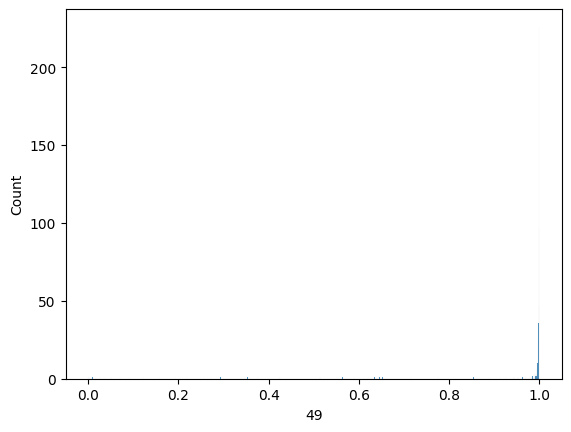

In [ ]:
mutated_sites=set(mut_info_combos["Mutation"])
print(mutated_sites)
#strip out letters
import seaborn
#sns.histplot(entropy_wide.iloc[-1,2:])
sns.histplot(probability_wide.iloc[-1,2:])

numeric_positions = [int(re.search(r'\d+', site).group()) for site in mutated_sites]
print(numeric_positions) # Sort the list for easier reading/comparison


target_series = probability_wide.iloc[-1, 2:]

# Convert the target series to a dictionary for fast lookup: {position: probability}
# Assuming column names (indices) are the residue positions (as in the mock setup)
position_to_prob = target_series.to_dict()

# Calculate Ranks: Assign a rank (1 being highest probability)
# Get the values and sort them in descending order
sorted_probs = target_series.sort_values(ascending=True)
# Create a rank series (using .rank() is safer for ties, but a simple lookup is faster here)
# Rank is 1 + index in the sorted list (since index starts at 0)
position_to_rank = {pos: rank + 1 for rank, pos in enumerate(sorted_probs.index)}
print(position_to_rank)
print(probability_wide.columns)

# Rank the max non-reference probabilities (highest value = rank 1)
# Create position-indexed ranking for max_non_reference_probs
max_nonref_with_positions = [(i+1, val) for i, val in enumerate(max_non_reference_probs)]
# Sort by value descending (highest first)
sorted_max_nonref = sorted(max_nonref_with_positions, key=lambda x: x[1], reverse=True)
# Create rank lookup: position -> rank (1 = highest)
position_to_nonref_rank = {pos: rank + 1 for rank, (pos, val) in enumerate(sorted_max_nonref)}

results = []
for mut_num, pos in enumerate(numeric_positions):
    prob = probability_wide["probability_"+str(pos)].tail(1).item()
    entropy=entropy_wide["entropy_"+str(pos)].tail(1).item()
    rank = position_to_rank["probability_"+str(pos)]
    # rank non-reference peak:
    rank_nonref = position_to_nonref_rank[pos]
    max_nonref_prob = max_non_reference_probs[pos-1]  # Get the actual max non-ref probability

    results.append({
        "mutation": list(mutated_sites)[mut_num],
        "Position": pos,
        "Probability_reference": prob,
        "entropy":entropy,
        "prob_mutation":mut_info_combos["probability"][(mut_info_combos["Mutation"]==list(mutated_sites)[mut_num] ) & 
                                        (mut_info_combos["Backbone"]=="Reference" )].item(),
        "Rank_probability": rank,
        "Max_non_reference_probability": max_nonref_prob,
        "Rank_max_non_reference": rank_nonref
    })

# Convert the results list to a DataFrame for clean, tabular output
results_df = pd.DataFrame(results).sort_values(by="Position").reset_index(drop=True)
# flatten mutation_prob_matrix



([<matplotlib.axis.XTick at 0x7f8810a9dfa0>,
 [Text(0, 0, '1'),
  Text(10, 0, '11'),
  Text(20, 0, '21'),
  Text(30, 0, '31'),
  Text(40, 0, '41'),
  Text(50, 0, '51'),
  Text(60, 0, '61'),
  Text(70, 0, '71'),
  Text(80, 0, '81'),
  Text(90, 0, '91'),
  Text(100, 0, '101'),
  Text(110, 0, '111'),
  Text(120, 0, '121'),
  Text(130, 0, '131'),
  Text(140, 0, '141'),
  Text(150, 0, '151'),
  Text(160, 0, '161'),
  Text(170, 0, '171'),
  Text(180, 0, '181'),
  Text(190, 0, '191'),
  Text(200, 0, '201'),
  Text(210, 0, '211'),
  Text(220, 0, '221'),
  Text(230, 0, '231'),
  Text(240, 0, '241'),
  Text(250, 0, '251'),
  Text(260, 0, '261'),
  Text(270, 0, '271'),
  Text(280, 0, '281'),
  Text(290, 0, '291'),
  Text(300, 0, '301'),
  Text(310, 0, '311'),
  Text(320, 0, '321'),
  Text(330, 0, '331'),
  Text(340, 0, '341'),
  Text(350, 0, '351'),
  Text(360, 0, '361'),
  Text(370, 0, '371'),
  Text(380, 0, '381'),
  Text(390, 0, '391'),
  Text(400, 0, '401'),
  Text(410, 0, '411'),
  Text(420,

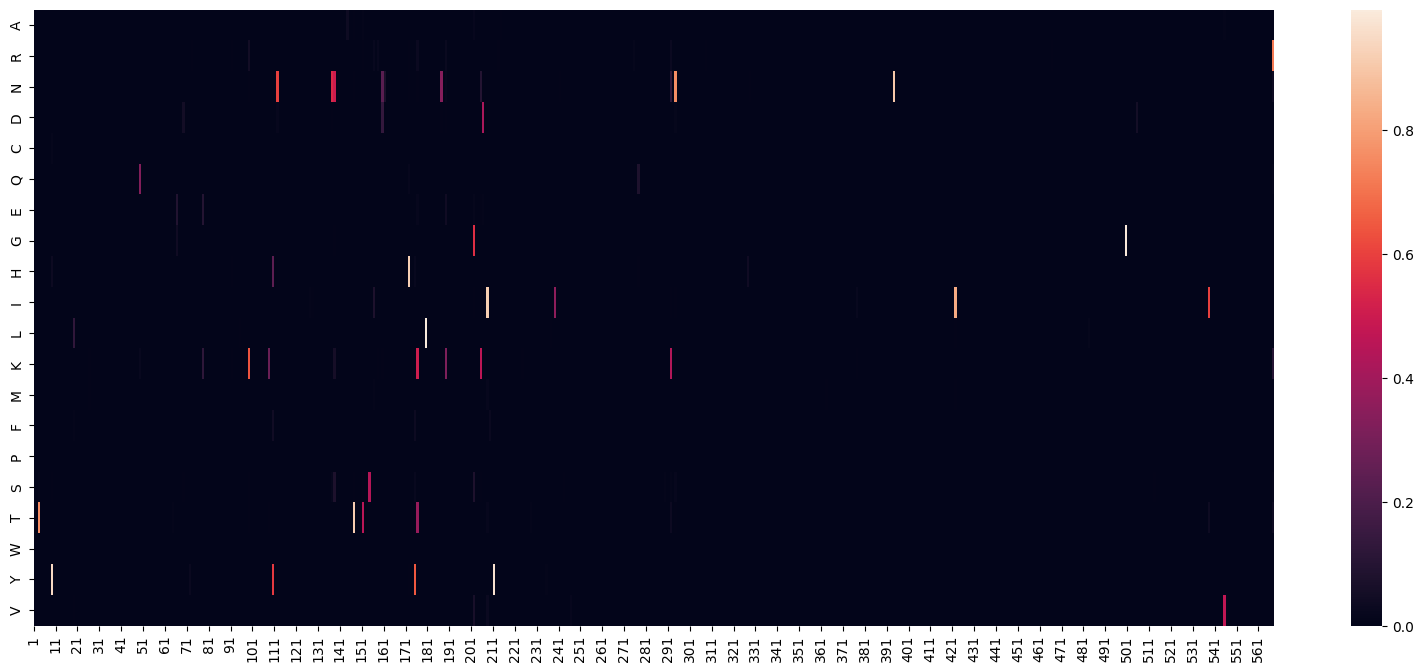

In [ ]:
mutation_prob_flat = mutation_prob_matrix.flatten()
results_df["probability_percentile"] = np.sum(mutation_prob_flat < results_df["Max_non_reference_probability"].values[:, None], axis=1) / len(mutation_prob_flat) * 100
results_df

# seaborn heatmap of mutation_prob_flat
plt.figure(figsize=(20, 8))
#only label every tenth x axis tick

seaborn.heatmap(mutation_prob_matrix, xticklabels=positions, yticklabels=amino_acids)
plt.xticks(ticks=np.arange(0, len(positions), 10), labels=np.array(positions)[::10])



<Axes: ylabel='Count'>

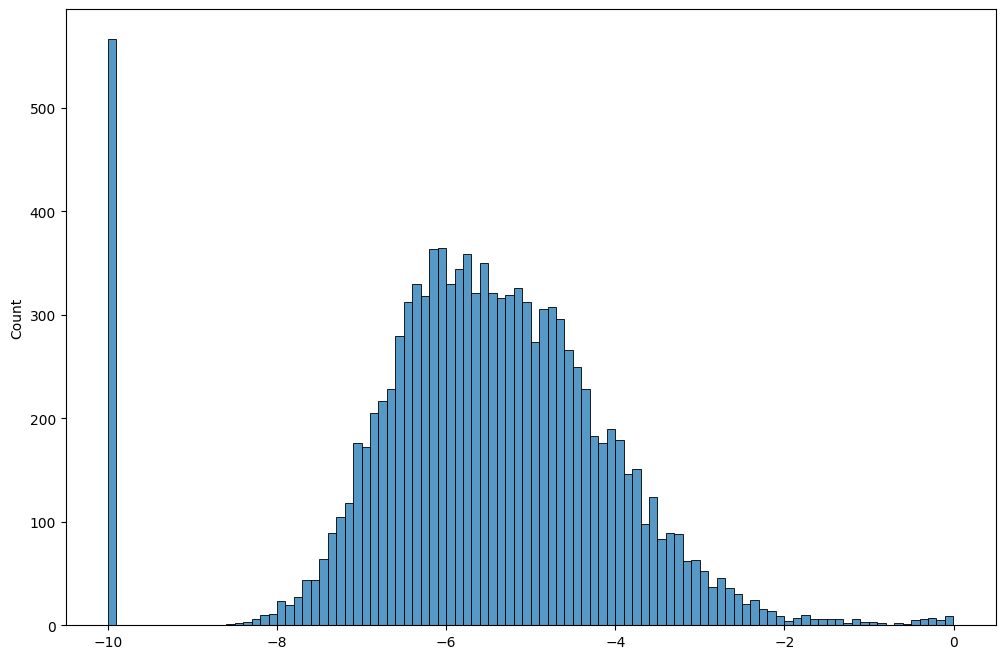

In [31]:
# seaborn histogram of mutation_prob_flat
plt.figure(figsize=(12, 8))
# log x axis before plotting
mutation_prob_matrix_log=np.log10(mutation_prob_matrix + 1e-10)  # add small constant to avoid log(0)
sns.histplot(mutation_prob_matrix_log.flatten(), bins=100)
#log yaxis log x axis
#plt.yscale('log')


In [ ]:
mut_info_combos.head()

,Mutation,rel_grammar,rel_seq_grammar,narrow_seq_grammar,relative_narrow_seq_grammar,semanatic_score,probability,Backbone
0,S160N,-0.946969,-3.248863,-75.576599,-3.710403,6.596790,0.238815,K18N
1,N174D,-6.359474,3.556679,-68.354645,3.987740,9.146610,0.001715,K18N
2,I176K,2.146142,-0.119713,-72.426292,-2.896835,4.435177,0.508805,K18N
3,Q189R,-3.210114,-1.844139,-73.885643,-1.997269,12.311827,0.025399,K18N
4,T344A,-7.628034,-1.332642,-72.153183,0.196495,2.133473,0.000486,K18N


In [ ]:
mut_info_combos["rel_reference_grammar"]=mut_info_combos["rel_grammar"]-mut_info_combos.merge(mut_info_combos[mut_info_combos['Backbone']=="Reference"][['Mutation','rel_grammar']],on='Mutation',how='left')['rel_grammar_y']

In [ ]:
mut_info_combos["rel_reference_grammar"]=mut_info_combos["rel_grammar"]-mut_info_combos.merge(mut_info_combos[mut_info_combos['Backbone']=="Reference"][['Mutation','rel_grammar']],on='Mutation',how='left')['rel_grammar_y']
#print most shifted mutations compared to reference

backbone=backbone_id.split("|")[-1]
mut_info_combos.to_csv("/home2/oml4h/PLM_SARS-CoV-2/Results/{}_epistasis_mutation_info_spyros_model_combos_backbone{}.csv".format(sub_mod),index=False)

In [ ]:
mut_info_combos.sort_values(by="rel_reference_grammar",ascending=False).head(10)

,Mutation,rel_grammar,rel_seq_grammar,narrow_seq_grammar,relative_narrow_seq_grammar,semanatic_score,probability,Backbone,rel_reference_grammar
76,Q189R,-3.753054,-1.321114,-68.414856,-1.336807,11.078470,0.018813,K205R,1.080708
34,I176K,2.502821,-1.457603,-73.264793,-4.463516,4.574855,0.581206,S160N,0.639933
11,T151K,-7.349810,-2.114006,-70.704178,-1.441864,2.477392,0.000642,N138D,0.443464
86,Q189R,-4.406815,-1.399269,-69.377243,-1.117638,11.471137,0.009943,K292E,0.426947
74,N174D,-6.439708,3.224854,-63.564598,3.720032,9.491597,0.001575,K205R,0.360170
47,K292E,-6.953505,-1.241058,-64.825096,-0.544456,6.006088,0.000948,N174D,0.322288
67,K292E,-6.958533,-1.370560,-69.084930,-0.599594,6.099527,0.000944,Q189R,0.317259
46,K205R,-6.725054,0.215141,-63.449837,0.830803,4.923565,0.001191,N174D,0.277113
39,S394N,2.532387,1.710068,-70.135956,-0.902740,3.028002,0.922062,S160N,0.264209
14,I176K,2.102611,-0.768341,-69.991432,-3.541443,4.290155,0.491018,N138D,0.239723


In [ ]:
epistatic_sum=mut_info_combos.groupby('Backbone')['rel_reference_grammar'].sum().reset_index().sort_values(by='rel_reference_grammar',ascending=False)
print(epistatic_sum.head(11))
epistatic_sum.to_csv("/home2/oml4h/PLM_SARS-CoV-2/Results/{}_epistasis_epistatic_sums.csv".format(sub_mod),index=False)

     Backbone  rel_reference_grammar
2       K205R               1.389331
5       N174D               0.672176
4       N138D               0.589418
6       Q189R               0.525393
3       K292E               0.466826
10      T151K               0.386889
7   Reference               0.000000
11      T344A              -0.035750
1        K18N              -0.050179
9       S394N              -0.104695
0       I176K              -0.715940


In [ ]:
megatable = []

for k in mutation_dictionary.keys():
    if k == 'Reference':
        continue
    relative_grammaticality = all_mutations[k][k]['S:0']["relative_grammaticality"]
    relative_sequence_grammaticality = all_mutations[k][k]['S:0']["relative_sequence_grammaticality"]
    semantic_score = all_mutations[k][k]['S:0']["semantic_score"]

    mutations = pd.DataFrame({'mutation':k,
                            'relative_grammaticality':relative_grammaticality,
                            'relative_sequence_grammaticality':relative_sequence_grammaticality,
                            'semantic_score':semantic_score,},index=[0])
    mutations.mutations = k
    megatable.append(mutations)
megatable_df = pd.concat(megatable)

if backbone == ids[len(ids)-1]:
    for mut in  mutation_dictionary.keys():
        megatable_df.mutation = megatable_df.mutation.str.replace(mut,mutation_dictionary[mut])
megatable_df

NameError: name 'all_mutations' is not defined

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler((0,1))

megatable_df['scaled_relative_grammaticality'] = mms.fit_transform(-megatable_df.relative_grammaticality.values.reshape(-1,1)).ravel()
megatable_df['scaled_relative_sequence_grammaticality'] = mms.fit_transform(-megatable_df.relative_sequence_grammaticality.values.reshape(-1,1)).ravel()

In [ ]:
megatable_df.sort_values('relative_grammaticality',ascending=False)

In [ ]:
import torch
lsoftmax = torch.nn.LogSoftmax(dim=1)

In [ ]:
def outside_std(column):
    filtered_vals = []
    for c in column:
        if c >=(column.mean() + (column.std()*2)) or c <= (column.mean() - (column.std()*2)):
            filtered_vals.append(c)
        else:
            filtered_vals.append(np.nan)
    return filtered_vals


In [ ]:
reference_logits_table = []
for k in all_mutations.keys():
    print(all_mutations[k].keys())
    backbone_logits = all_mutations[k]['Reference']['S:0']['Logits']
    backbone_logits = format_logits(backbone_logits,alphabet)
    backbone_logits = remap_logits(backbone_logits,sequences['Wuhan'], reference_spike_sequence)
    backbone_ref_seq_logits = [row[row.Sequence] if row.Sequence != '-' else np.nan for i,row in backbone_logits.iterrows()]

    for mutation in all_mutations[k].keys():
        if mutation != 'Reference':
            if backbone == 'BA.1':
                mutated_sequence = revert_sequence(reference_spike_sequence,[mutation])
            else:
                mutated_sequence = mutate_sequence(reference_spike_sequence,[mutation])

            mutated_logits = format_logits(all_mutations[k][mutation]['S:0']['Logits'],alphabet)
            mutated_logits = remap_logits(mutated_logits,sequences['Wuhan'], mutated_sequence, )
            mutated_seq_logits = [row[row.Sequence]  if row.Sequence != '-' else np.nan for i,row in mutated_logits.iterrows()]
            
            if backbone == 'BA.1':
                # Difference is backbone - mutation here since the "mutation" is actually a reversion
                difference = np.exp(backbone_ref_seq_logits) -  np.exp(mutated_seq_logits)
                pllr =  np.array(backbone_ref_seq_logits)- np.array(mutated_seq_logits)
            else:
                difference =  np.exp(mutated_seq_logits) - np.exp(backbone_ref_seq_logits)
                pllr =  np.array(mutated_seq_logits) - np.array(backbone_ref_seq_logits)

            df = pd.DataFrame(
                {'source_sequence':list(backbone_logits.Sequence),
                'target_sequence':list(mutated_logits.Sequence),
                'source_logits':backbone_ref_seq_logits,
                'target_logits':mutated_seq_logits,
                'change':difference,
                'ratio':pllr,
                'position':range(1,len(difference)+1)})
                
            df['masked_change'] =[row.change if row.source_sequence == row.target_sequence else np.nan for i, row in df.iterrows()]
            df['masked_ratio'] =[row.ratio if row.source_sequence == row.target_sequence else np.nan for i, row in df.iterrows()]
            
            local_max_change = df.masked_change.mean()+(df.masked_change.std()*2)
            local_min_change = df.masked_change.mean()-(df.masked_change.std()*2)

            local_max_ratio = df.masked_ratio.mean()+(df.masked_ratio.std()*2)
            local_min_ratio = df.masked_ratio.mean()-(df.masked_ratio.std()*2)

            df['significant_masked_change_local'] = [ check_valid(m,local_min_change,local_max_change) for m in df. masked_change]
            df['significant_masked_ratio_local'] = [ check_valid(m,local_min_ratio,local_max_ratio) for m in df.masked_ratio]

            df['mutation'] = mutation_dictionary[mutation]
            reference_logits_table.append(df)
reference_logits_table = pd.concat(reference_logits_table,axis=0)

max_change = reference_logits_table.masked_change.mean()+(reference_logits_table.masked_change.std()*2)
min_change = reference_logits_table.masked_change.mean()-(reference_logits_table.masked_change.std()*2)

max_ratio = reference_logits_table.masked_ratio.mean()+(reference_logits_table.masked_ratio.std()*2)
min_ratio = reference_logits_table.masked_ratio.mean()-(reference_logits_table.masked_ratio.std()*2)

reference_logits_table['significant_masked_change'] = [ check_valid(m,min_change,max_change) for m in reference_logits_table.masked_change]
reference_logits_table['significant_masked_ratio'] = [ check_valid(m,min_ratio,max_ratio) for m in reference_logits_table.masked_ratio]

max_change = reference_logits_table.masked_change.round(4).mean()+(reference_logits_table.masked_change.round(4).std()*2)
min_change = reference_logits_table.masked_change.round(4).mean()-(reference_logits_table.masked_change.round(4).std()*2)

reference_logits_table['significant_masked_change_rounded'] = [ check_valid(m,min_change,max_change) for m in reference_logits_table.masked_change.round(4)]


In [ ]:
import plotly.express as px
fig = px.line(reference_logits_table, x="position", y="masked_change",color="mutation", facet_col='mutation',facet_col_wrap=6,height=1000, width=1500, hover_data=['position','change','mutation'])
fig.update_traces(marker={'size': 3})
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter(reference_logits_table, x="position", y="significant_masked_change_rounded",color="mutation", facet_col='mutation',facet_col_wrap=6,height=1000, width=1500, hover_data=['position','change','mutation'])
fig.update_traces(marker={'size': 3})
fig.show()

In [ ]:
reference_logits_table.to_csv('./Epistasis/Revisions_Omicron_Epistasis.csv',index=False)

In [ ]:
reference_logits_table = pd.read_csv('./Epistasis/Revisions_Omicron_Epistasis.csv')

In [ ]:
max_change = reference_logits_table.masked_change.mean()+(reference_logits_table.masked_change.std())
min_change = reference_logits_table.masked_change.mean()-(reference_logits_table.masked_change.std())
reference_logits_table['single_significant_masked_change'] = [ check_valid(m,min_change,max_change) for m in reference_logits_table.masked_change]

In [ ]:
reference_logits_table.to_csv('Revisions_Omicron_Epistasis_with_single_std.csv')

In [ ]:
import plotly.express as px
fig = px.scatter(reference_logits_table, x="position", y="single_significant_masked_change",color="mutation", facet_col='mutation',facet_col_wrap=6,height=1000, width=1500, hover_data=['position','change','mutation'])
fig.update_traces(marker={'size': 3})
fig.show()

In [ ]:
ba1_mutated_positions = reference_logits_table.mutation.str[1:-1].astype(int).unique()
ba1_mutated_positions

In [ ]:
one_std_identified_interactions = reference_logits_table[(reference_logits_table.single_significant_masked_change.isna() == False) & (reference_logits_table.position.isin(ba1_mutated_positions)) ]

In [ ]:
two_std_identified_interactions = reference_logits_table[(reference_logits_table.significant_masked_change.isna() == False) & (reference_logits_table.position.isin(ba1_mutated_positions)) ]

In [ ]:
px.scatter(two_std_identified_interactions,x=two_std_identified_interactions.position.astype(str),y=two_std_identified_interactions.mutation.astype(str))

In [ ]:
px.scatter(one_std_identified_interactions,x=one_std_identified_interactions.position.astype(str),y=one_std_identified_interactions.mutation.astype(str))

In [ ]:
identified_interactions = one_std_identified_interactions[['position','mutation']]
identified_interactions['mutated_position'] = identified_interactions.mutation.str[1:-1].astype(int)
swap_interactions = identified_interactions[identified_interactions.position < identified_interactions.mutated_position]
swap_interactions.rename(columns={'position':'position_1','mutated_position':'position_2'},inplace=True)
swap_interactions_2 = identified_interactions[identified_interactions.position >= identified_interactions.mutated_position]
swap_interactions_2.rename(columns={'mutated_position':'position_1','position':'position_2'},inplace=True)

swap_interactions = pd.concat([swap_interactions,swap_interactions_2])
swap_interactions.to_csv('Omicron_One_Std_Interactions.csv',index=False)

In [ ]:
identified_interactions = two_std_identified_interactions[['position','mutation']]
identified_interactions['mutated_position'] = identified_interactions.mutation.str[1:-1].astype(int)
swap_interactions = identified_interactions[identified_interactions.position < identified_interactions.mutated_position]
swap_interactions.rename(columns={'position':'position_1','mutated_position':'position_2'},inplace=True)
swap_interactions_2 = identified_interactions[identified_interactions.position >= identified_interactions.mutated_position]
swap_interactions_2.rename(columns={'mutated_position':'position_1','position':'position_2'},inplace=True)

swap_interactions = pd.concat([swap_interactions,swap_interactions_2])
swap_interactions.to_csv('Omicron_Two_Std_Interactions.csv',index=False)